In [1]:
!nvidia-smi

Mon May 10 18:04:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00165208days (142.74sec)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [4]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!cp "drive/My Drive/ImageNet/cortical_ImagenetTrain2.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest2.zip" /content/

In [21]:
!unzip -nq "cortical_ImagenetTrain2.zip"
!unzip -nq "cortical_ImagenetTest2.zip"

In [22]:
def make_path_list(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list


In [29]:
rootpathTrain ='cortical_ImagenetTrain2/'
rootpathTest ='cortical_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [30]:
def str_convert(label):
    df = pd.DataFrame(({'label_' : label}))
    df['label_'] = df['label_'].astype('category')
    df.dtypes
    df['label'] = df['label_'].cat.codes
    label = df['label'].tolist()

    return label

In [31]:
class ImageNetDataset(data.Dataset):
    def __init__(self, img_list, phase, transform):
        self.img_list = img_list
        self.label_name = [x.split("/")[1] for x in img_list]
        self.label = str_convert(self.label_name)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        """
        Return pre-processed tensor images and labels
        """
        #img, anno_class_img, label = self.pull_item(index)
        #return img, anno_class_img, label
        img, label = self.pull_item(index)
        return img, label
    
    def get_label_relation(self):
        df = pd.DataFrame({'name' : self.label_name, 'num' : self.label})
        classes_list=df[~df.duplicated()].sort_values(by='num')['name'].values.tolist()
        
        return classes_list

    def pull_item(self, index):
        # read image
        image_file_path = self.img_list[index]
        img = PIL.Image.open(image_file_path).convert("RGB")   # [height][width][RGB]
        
        # transform
        #img = transforms.functional.to_tensor(img)
        #anno_class_img = torch.from_numpy(anno_class_img)
        img = self.transform(img)
        #anno_class_img = self.transform(anno_class_img)

        # label
        label = self.label[index]
        
        #return img, anno_class_img, label
        return img, label

In [32]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [33]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [34]:
classes_list

['apple',
 'banana',
 'bear',
 'bell_pepper',
 'bird',
 'broccoli',
 'cat',
 'cauliflower',
 'cow',
 'dog',
 'elephant',
 'fox',
 'goat',
 'horse',
 'mashed_potato',
 'orange',
 'pineapple',
 'pomegranate',
 'tomato',
 'zebra']

In [35]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [36]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [37]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

14164

In [38]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


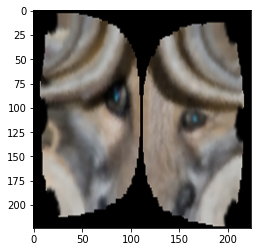

In [42]:
index = 4
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [43]:
label

11

In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### Network model

In [ ]:
class TinyCNN(nn.Module):
    """
    TinyCNN: https://arxiv.org/abs/1911.06777v1

    fc1, fc2 should be modified for each image size and class num.

    model=TinyCNN()
    model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=N_CLASSES)
    model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)
    """

    def __init__(self, DROPOUT=False):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   32,  3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(32,  64,  3, 1, 1, bias=False)
        self.conv3 = nn.Conv2d(64,  128, 3, 1, 1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1, bias=False)

        self.relu = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128 * 14 * 14, 100), nn.Dropout2d(p=0.5), self.relu,
                                  nn.Linear(100, 20), nn.Dropout2d(p=0.4))
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

    def encode(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.encode(x)

        x = x.view(x.size(0),-1)
        x = self.classifier(x)

        return self.relu(x)

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 100

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Model preparation

In [ ]:
# TinyCNN model instance set
model=TinyCNN()

# FC layer input&output size change
#model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=100)
#model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)

model.cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


TinyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=100, bias=True)
    (1): Dropout2d(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=20, bias=True)
    (4): Dropout2d(p=0.4, inplace=False)
  )
)

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    best_model=model; best_accuracy = 0;
    stats = []; training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    for epoch in range(num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_corrects)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_corrects / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%5==0:
            total_name = name+"_epoch"+str(epoch)+".pth"
            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save(model.state_dict(), path)
        print('-------------')

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [ ]:
name = "04_1_simple_again"
best_model, stats = train_model(model, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, "simple", DEBUG)

Epoch 1/100
-------------



1216
train Loss: 0.0927 Acc: 8.5851



480
val Loss: 0.0901 Acc: 13.5593
-------------
Epoch 2/100
-------------



1544
train Loss: 0.0911 Acc: 10.9009



617
val Loss: 0.0886 Acc: 17.4294
-------------
Epoch 3/100
-------------



1763
train Loss: 0.0904 Acc: 12.4470



682
val Loss: 0.0884 Acc: 19.2655
-------------
Epoch 4/100
-------------



2059
train Loss: 0.0893 Acc: 14.5369



774
val Loss: 0.0858 Acc: 21.8644
-------------
Epoch 5/100
-------------



2245
train Loss: 0.0884 Acc: 15.8500



811
val Loss: 0.0848 Acc: 22.9096
-------------
Epoch 6/100
-------------



2242
train Loss: 0.0883 Acc: 15.8289



815
val Loss: 0.0866 Acc: 23.0226
-------------
Epoch 7/100
-------------



2435
train Loss: 0.0877 Acc: 17.1915



941
val Loss: 0.0840 Acc: 26.5819
-------------
Epoch 8/100
-------------



2548
train Loss: 0.0870 Acc: 17.9893



990
val Loss: 0.0823 Acc: 27.9661
-------------
Epoch 9/100
-------------



2571
train Loss: 0.0868 Acc: 18.1517



959
val Loss: 0.0830 Acc: 27.0904
-------------
Epoch 10/100
-------------



2676
train Loss: 0.0861 Acc: 18.8930



940
val Loss: 0.0818 Acc: 26.5537
-------------
Epoch 11/100
-------------



2721
train Loss: 0.0856 Acc: 19.2107



1103
val Loss: 0.0809 Acc: 31.1582
-------------
Epoch 12/100
-------------



2816
train Loss: 0.0854 Acc: 19.8814



1051
val Loss: 0.0810 Acc: 29.6893
-------------
Epoch 13/100
-------------



3018
train Loss: 0.0843 Acc: 21.3075



1030
val Loss: 0.0809 Acc: 29.0960
-------------
Epoch 14/100
-------------



3146
train Loss: 0.0839 Acc: 22.2112



1050
val Loss: 0.0796 Acc: 29.6610
-------------
Epoch 15/100
-------------



3096
train Loss: 0.0835 Acc: 21.8582



1259
val Loss: 0.0778 Acc: 35.5650
-------------
Epoch 16/100
-------------



3303
train Loss: 0.0824 Acc: 23.3197



1240
val Loss: 0.0766 Acc: 35.0282
-------------
Epoch 17/100
-------------



3451
train Loss: 0.0821 Acc: 24.3646



1186
val Loss: 0.0768 Acc: 33.5028
-------------
Epoch 18/100
-------------



3564
train Loss: 0.0815 Acc: 25.1624



1266
val Loss: 0.0772 Acc: 35.7627
-------------
Epoch 19/100
-------------



3661
train Loss: 0.0805 Acc: 25.8472



1259
val Loss: 0.0753 Acc: 35.5650
-------------
Epoch 20/100
-------------



3802
train Loss: 0.0797 Acc: 26.8427



1299
val Loss: 0.0770 Acc: 36.6949
-------------
Epoch 21/100
-------------



3878
train Loss: 0.0793 Acc: 27.3793



1266
val Loss: 0.0759 Acc: 35.7627
-------------
Epoch 22/100
-------------



4022
train Loss: 0.0786 Acc: 28.3959



1365
val Loss: 0.0735 Acc: 38.5593
-------------
Epoch 23/100
-------------



4168
train Loss: 0.0772 Acc: 29.4267



1398
val Loss: 0.0731 Acc: 39.4915
-------------
Epoch 24/100
-------------



4228
train Loss: 0.0773 Acc: 29.8503



1349
val Loss: 0.0740 Acc: 38.1073
-------------
Epoch 25/100
-------------



4344
train Loss: 0.0766 Acc: 30.6693



1377
val Loss: 0.0727 Acc: 38.8983
-------------
Epoch 26/100
-------------



4421
train Loss: 0.0759 Acc: 31.2129



1388
val Loss: 0.0732 Acc: 39.2090
-------------
Epoch 27/100
-------------



4534
train Loss: 0.0750 Acc: 32.0107



1356
val Loss: 0.0744 Acc: 38.3051
-------------
Epoch 28/100
-------------



4728
train Loss: 0.0741 Acc: 33.3804



1372
val Loss: 0.0724 Acc: 38.7571
-------------
Epoch 29/100
-------------



4765
train Loss: 0.0733 Acc: 33.6416



1415
val Loss: 0.0717 Acc: 39.9718
-------------
Epoch 30/100
-------------



4861
train Loss: 0.0731 Acc: 34.3194



1406
val Loss: 0.0730 Acc: 39.7175
-------------
Epoch 31/100
-------------



4891
train Loss: 0.0728 Acc: 34.5312



1380
val Loss: 0.0732 Acc: 38.9831
-------------
Epoch 32/100
-------------



5069
train Loss: 0.0717 Acc: 35.7879



1432
val Loss: 0.0719 Acc: 40.4520
-------------
Epoch 33/100
-------------



5210
train Loss: 0.0708 Acc: 36.7834



1345
val Loss: 0.0732 Acc: 37.9944
-------------
Epoch 34/100
-------------



5249
train Loss: 0.0704 Acc: 37.0587



1409
val Loss: 0.0731 Acc: 39.8023
-------------
Epoch 35/100
-------------



5419
train Loss: 0.0691 Acc: 38.2590



1357
val Loss: 0.0730 Acc: 38.3333
-------------
Epoch 36/100
-------------



5496
train Loss: 0.0685 Acc: 38.8026



1408
val Loss: 0.0726 Acc: 39.7740
-------------
Epoch 37/100
-------------



5456
train Loss: 0.0688 Acc: 38.5202



1369
val Loss: 0.0726 Acc: 38.6723
-------------
Epoch 38/100
-------------



5574
train Loss: 0.0679 Acc: 39.3533



1337
val Loss: 0.0740 Acc: 37.7684
-------------
Epoch 39/100
-------------



5564
train Loss: 0.0678 Acc: 39.2827



1395
val Loss: 0.0730 Acc: 39.4068
-------------
Epoch 40/100
-------------



5668
train Loss: 0.0671 Acc: 40.0169



1304
val Loss: 0.0749 Acc: 36.8362
-------------
Epoch 41/100
-------------



5827
train Loss: 0.0660 Acc: 41.1395



1319
val Loss: 0.0743 Acc: 37.2599
-------------
Epoch 42/100
-------------



5912
train Loss: 0.0655 Acc: 41.7396



1357
val Loss: 0.0740 Acc: 38.3333
-------------
Epoch 43/100
-------------



5870
train Loss: 0.0661 Acc: 41.4431



1347
val Loss: 0.0733 Acc: 38.0508
-------------
Epoch 44/100
-------------



5939
train Loss: 0.0653 Acc: 41.9302



1335
val Loss: 0.0744 Acc: 37.7119
-------------
Epoch 45/100
-------------



5900
train Loss: 0.0654 Acc: 41.6549



1353
val Loss: 0.0734 Acc: 38.2203
-------------
Epoch 46/100
-------------



6097
train Loss: 0.0641 Acc: 43.0457



1390
val Loss: 0.0741 Acc: 39.2655
-------------
Epoch 47/100
-------------



6036
train Loss: 0.0642 Acc: 42.6151



1406
val Loss: 0.0730 Acc: 39.7175
-------------
Epoch 48/100
-------------



6181
train Loss: 0.0638 Acc: 43.6388



1357
val Loss: 0.0729 Acc: 38.3333
-------------
Epoch 49/100
-------------



6153
train Loss: 0.0635 Acc: 43.4411



1356
val Loss: 0.0748 Acc: 38.3051
-------------
Epoch 50/100
-------------



6107
train Loss: 0.0640 Acc: 43.1164



1353
val Loss: 0.0747 Acc: 38.2203
-------------
Epoch 51/100
-------------



6234
train Loss: 0.0632 Acc: 44.0130



1328
val Loss: 0.0742 Acc: 37.5141
-------------
Epoch 52/100
-------------



6229
train Loss: 0.0631 Acc: 43.9777



1346
val Loss: 0.0746 Acc: 38.0226
-------------
Epoch 53/100
-------------



6252
train Loss: 0.0627 Acc: 44.1401



1299
val Loss: 0.0760 Acc: 36.6949
-------------
Epoch 54/100
-------------



6359
train Loss: 0.0622 Acc: 44.8955



1357
val Loss: 0.0742 Acc: 38.3333
-------------
Epoch 55/100
-------------



6301
train Loss: 0.0624 Acc: 44.4860



1307
val Loss: 0.0757 Acc: 36.9209
-------------
Epoch 56/100
-------------



6198
train Loss: 0.0635 Acc: 43.7588



1305
val Loss: 0.0751 Acc: 36.8644
-------------
Epoch 57/100
-------------



6347
train Loss: 0.0624 Acc: 44.8108



1339
val Loss: 0.0741 Acc: 37.8249
-------------
Epoch 58/100
-------------



6483
train Loss: 0.0612 Acc: 45.7710



1352
val Loss: 0.0743 Acc: 38.1921
-------------
Epoch 59/100
-------------



6449
train Loss: 0.0614 Acc: 45.5309



1287
val Loss: 0.0757 Acc: 36.3559
-------------
Epoch 60/100
-------------



6468
train Loss: 0.0612 Acc: 45.6651



1336
val Loss: 0.0753 Acc: 37.7401
-------------
Epoch 61/100
-------------



6379
train Loss: 0.0616 Acc: 45.0367



1316
val Loss: 0.0750 Acc: 37.1751
-------------
Epoch 62/100
-------------



6632
train Loss: 0.0600 Acc: 46.8229



1357
val Loss: 0.0747 Acc: 38.3333
-------------
Epoch 63/100
-------------



6498
train Loss: 0.0608 Acc: 45.8769



1337
val Loss: 0.0740 Acc: 37.7684
-------------
Epoch 64/100
-------------



6578
train Loss: 0.0607 Acc: 46.4417



1320
val Loss: 0.0755 Acc: 37.2881
-------------
Epoch 65/100
-------------



6583
train Loss: 0.0607 Acc: 46.4770



1378
val Loss: 0.0731 Acc: 38.9266
-------------
Epoch 66/100
-------------



6506
train Loss: 0.0609 Acc: 45.9334



1262
val Loss: 0.0758 Acc: 35.6497
-------------
Epoch 67/100
-------------



6652
train Loss: 0.0602 Acc: 46.9641



1324
val Loss: 0.0752 Acc: 37.4011
-------------
Epoch 68/100
-------------



6641
train Loss: 0.0599 Acc: 46.8865



1320
val Loss: 0.0759 Acc: 37.2881
-------------
Epoch 69/100
-------------



6490
train Loss: 0.0612 Acc: 45.8204



1273
val Loss: 0.0763 Acc: 35.9605
-------------
Epoch 70/100
-------------



6543
train Loss: 0.0608 Acc: 46.1946



1278
val Loss: 0.0753 Acc: 36.1017
-------------
Epoch 71/100
-------------



6401
train Loss: 0.0624 Acc: 45.1920



1286
val Loss: 0.0759 Acc: 36.3277
-------------
Epoch 72/100
-------------



6509
train Loss: 0.0612 Acc: 45.9545



1344
val Loss: 0.0750 Acc: 37.9661
-------------
Epoch 73/100
-------------



6643
train Loss: 0.0600 Acc: 46.9006



1240
val Loss: 0.0766 Acc: 35.0282
-------------
Epoch 74/100
-------------



6637
train Loss: 0.0601 Acc: 46.8582



1276
val Loss: 0.0760 Acc: 36.0452
-------------
Epoch 75/100
-------------



6570
train Loss: 0.0602 Acc: 46.3852



1344
val Loss: 0.0759 Acc: 37.9661
-------------
Epoch 76/100
-------------



6544
train Loss: 0.0612 Acc: 46.2016



1210
val Loss: 0.0771 Acc: 34.1808
-------------
Epoch 77/100
-------------



6723
train Loss: 0.0597 Acc: 47.4654



1242
val Loss: 0.0771 Acc: 35.0847
-------------
Epoch 78/100
-------------



6623
train Loss: 0.0599 Acc: 46.7594



1264
val Loss: 0.0763 Acc: 35.7062
-------------
Epoch 79/100
-------------



6670
train Loss: 0.0600 Acc: 47.0912



1289
val Loss: 0.0769 Acc: 36.4124
-------------
Epoch 80/100
-------------



6489
train Loss: 0.0620 Acc: 45.8133



1282
val Loss: 0.0767 Acc: 36.2147
-------------
Epoch 81/100
-------------



6734
train Loss: 0.0598 Acc: 47.5431



1290
val Loss: 0.0755 Acc: 36.4407
-------------
Epoch 82/100
-------------



6699
train Loss: 0.0599 Acc: 47.2960



1310
val Loss: 0.0755 Acc: 37.0056
-------------
Epoch 83/100
-------------



6772
train Loss: 0.0595 Acc: 47.8114



1324
val Loss: 0.0758 Acc: 37.4011
-------------
Epoch 84/100
-------------



6747
train Loss: 0.0592 Acc: 47.6348



1263
val Loss: 0.0766 Acc: 35.6780
-------------
Epoch 85/100
-------------



6680
train Loss: 0.0597 Acc: 47.1618



1285
val Loss: 0.0763 Acc: 36.2994
-------------
Epoch 86/100
-------------



6630
train Loss: 0.0605 Acc: 46.8088



1304
val Loss: 0.0762 Acc: 36.8362
-------------
Epoch 87/100
-------------



6648
train Loss: 0.0603 Acc: 46.9359



1274
val Loss: 0.0769 Acc: 35.9887
-------------
Epoch 88/100
-------------



6512
train Loss: 0.0615 Acc: 45.9757



1220
val Loss: 0.0770 Acc: 34.4633
-------------
Epoch 89/100
-------------



6698
train Loss: 0.0600 Acc: 47.2889



1191
val Loss: 0.0783 Acc: 33.6441
-------------
Epoch 90/100
-------------



6571
train Loss: 0.0609 Acc: 46.3923



1226
val Loss: 0.0781 Acc: 34.6328
-------------
Epoch 91/100
-------------



6671
train Loss: 0.0600 Acc: 47.0983



1202
val Loss: 0.0786 Acc: 33.9548
-------------
Epoch 92/100
-------------



6539
train Loss: 0.0615 Acc: 46.1663



1305
val Loss: 0.0757 Acc: 36.8644
-------------
Epoch 93/100
-------------



6506
train Loss: 0.0617 Acc: 45.9334



1171
val Loss: 0.0780 Acc: 33.0791
-------------
Epoch 94/100
-------------



6817
train Loss: 0.0590 Acc: 48.1291



1216
val Loss: 0.0782 Acc: 34.3503
-------------
Epoch 95/100
-------------



6481
train Loss: 0.0615 Acc: 45.7568



1237
val Loss: 0.0769 Acc: 34.9435
-------------
Epoch 96/100
-------------



6808
train Loss: 0.0598 Acc: 48.0655



1238
val Loss: 0.0780 Acc: 34.9718
-------------
Epoch 97/100
-------------



6596
train Loss: 0.0613 Acc: 46.5688



1217
val Loss: 0.0778 Acc: 34.3785
-------------
Epoch 98/100
-------------



6292
train Loss: 0.0633 Acc: 44.4225



1218
val Loss: 0.0778 Acc: 34.4068
-------------
Epoch 99/100
-------------



6287
train Loss: 0.0641 Acc: 44.3872



1239
val Loss: 0.0775 Acc: 35.0000
-------------
Epoch 100/100
-------------



6619
train Loss: 0.0614 Acc: 46.7311



1222
val Loss: 0.0787 Acc: 34.5198
-------------
Lowest training loss 0.058979042840185764
Lowest validation loss 0.07169871512105909
Highest training accuracy 48.129059587687095
Highest validation accuracy 40.451977401129945
-------------


In [ ]:
# Save weights
path = F"/content/drive/My Drive/Colab Notebooks/PhD/simple/{name}.pth"
torch.save(best_model.state_dict(), path)

/content/drive/My Drive/Colab Notebooks/Graphs/04_1_simple_again_Loss _.png04_1_simple_again_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_1_simple_again_Accuracy _.png04_1_simple_again_Accuracy _.png


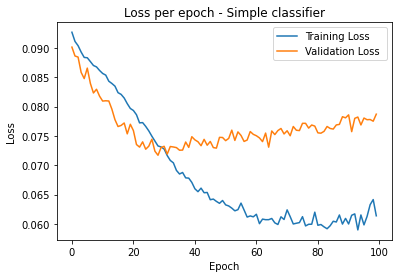

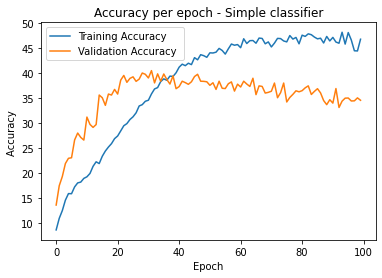

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.3737 
Testing Accuracy: 715/2000 (35.75%)
apple Class Accuracy: 17/100 (17.00%)
banana Class Accuracy: 39/100 (39.00%)
bear Class Accuracy: 36/100 (36.00%)
bell_pepper Class Accuracy: 23/100 (23.00%)
bird Class Accuracy: 17/100 (17.00%)
broccoli Class Accuracy: 40/100 (40.00%)
cat Class Accuracy: 34/100 (34.00%)
cauliflower Class Accuracy: 13/100 (13.00%)
cow Class Accuracy: 21/100 (21.00%)
dog Class Accuracy: 13/100 (13.00%)
elephant Class Accuracy: 46/100 (46.00%)
fox Class Accuracy: 61/100 (61.00%)
goat Class Accuracy: 16/100 (16.00%)
horse Class Accuracy: 14/100 (14.00%)
mashed_potato Class Accuracy: 51/100 (51.00%)
orange Class Accuracy: 56/100 (56.00%)
pineapple Class Accuracy: 38/100 (38.00%)
pomegranate Class Accuracy: 58/100 (58.00%)
tomato Class Accuracy: 50/100 (50.00%)
zebra Class Accuracy: 72/100 (72.00%)
Classifier has Acc=0.357 P=0.358 R=0.371 F1=0.346
               precision    recall  f1-score   support

        apple       0.27      0.17      0.21      

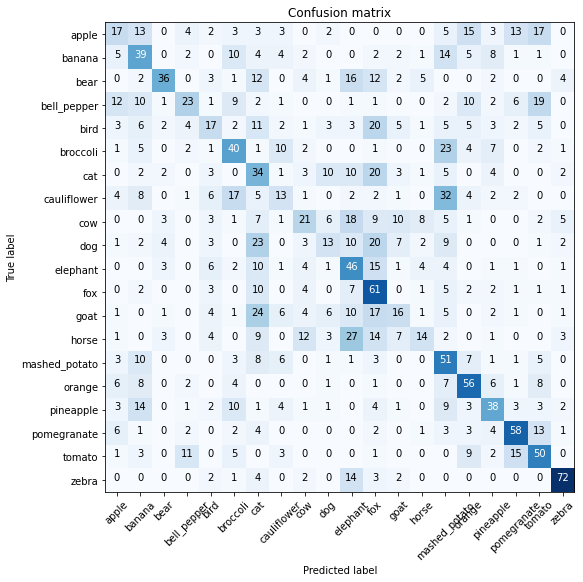

In [ ]:
result = test_model(best_model, criterion, name)